In [43]:
import requests
import numpy as np
import PIL.Image
from io import BytesIO
from IPython.display import display

Defining function to pull images from the Google Street View API.

In [44]:
def pull_street_view_image(api_key, longitude, latitude, fov = 90, heading = 0, pitch = 0, width = 800, height = 800):
# URL of the image you want to load
    image_url = f"https://maps.googleapis.com/maps/api/streetview?size=800x800&location={latitude},{longitude}&fov={fov}&heading={heading}&pitch={pitch}&key={api_key}"

    try:
        # Send an HTTP GET request to fetch the image
        response = requests.get(image_url)
        
        # Check if the request was successful (HTTP status code 200)
        if response.status_code == 200:
            # Get the image data as bytes
            image_data = response.content
            
            # Create a Pillow Image object from the image data
            img = PIL.Image.open(BytesIO(image_data))
            
        else:
            print(f"Failed to retrieve the image. Status code: {response.status_code}")

    except Exception as e:
        print(f"An errorr occurred: {str(e)}")

    return img

Test function

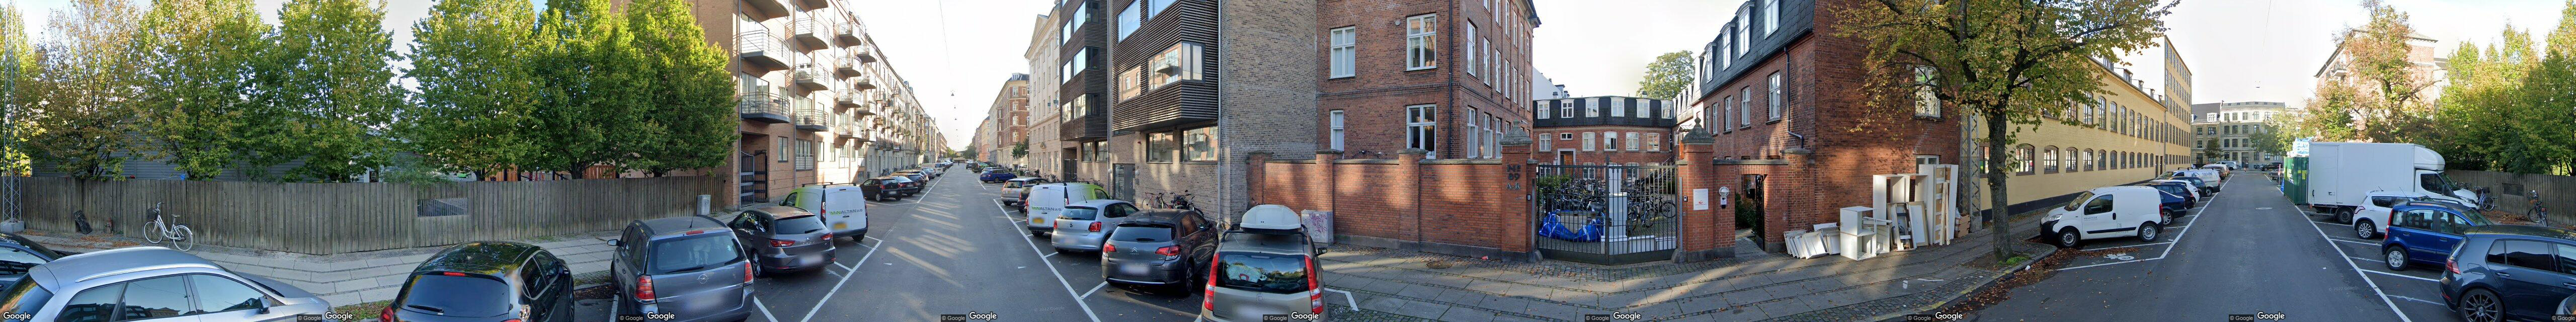

In [64]:
with open("API.txt", 'r') as file:
    api_key = file.read().strip()


longitude = 12.529604513710206
latitude = 55.68848331667608
fov = 45

headings = np.arange(0, 360, fov)
image_list = []
for heading in headings:
    new_image = pull_street_view_image(api_key, longitude, latitude, heading=heading, fov = fov)
    
    # Append the new image to the list
    image_list.append(new_image)

# Calculate the total width needed for the final image
total_width = sum([img.width for img in image_list])
max_height = max([img.height for img in image_list])

# Create a blank canvas for the final image
final_image = Image.new('RGB', (total_width, max_height))

# Paste each image onto the final image
x_offset = 0
for img in image_list:
    final_image.paste(img, (x_offset, 0))
    x_offset += img.width

# Display or save the final image
display(final_image)

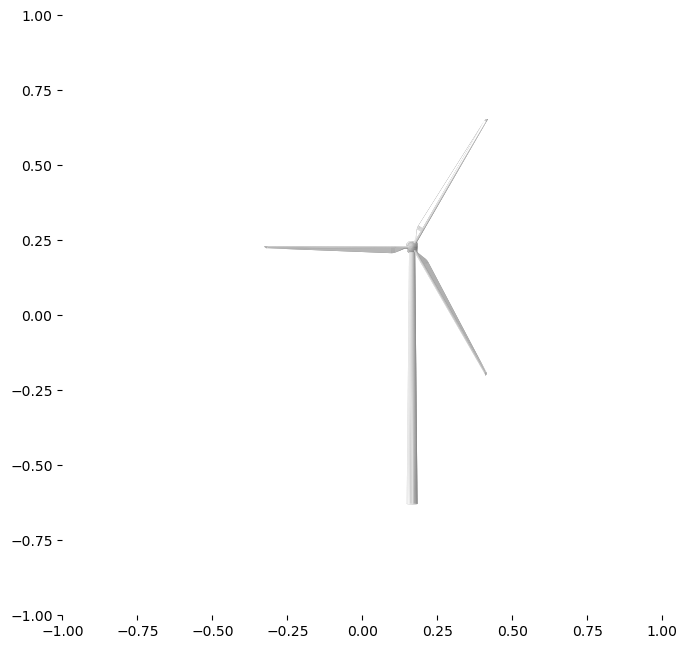

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import matplotlib as mpl
from PIL import Image, ImageChops

V, F = [], []
with open("turbine.obj") as f:
    for line in f.readlines():
        if line.startswith('#'):
            continue
        values = line.split()
        if not values:
            continue
        if values[0] == 'v':
            V.append([float(x) for x in values[1:4]])
        elif values[0] == 'f' :
            F.append([int(x.split("/", 1)[0]) for x in values[1:4]])
V, F = np.array(V), np.array(F)-1
V = (V-(V.max(0)+V.min(0))/2) / max(V.max(0)-V.min(0))

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)
ax = fig.add_subplot(111, projection="3d")
plt.axis('off')
ax.view_init(elev=0, azim=270)
plt.grid(visible=None)
ax.plot_trisurf(V[:, 0], V[:,1], F, V[:, 2], linewidth=0, antialiased=True, closed=True, color = "w")
limits = np.array([getattr(ax, f"get_{axis}lim")() for axis in "xyz"])
ax.set_box_aspect(np.ptp(limits, axis=1))
plt.savefig("turbine.png", dpi=300, transparent=True)
plt.show()


pil_image = Image.open("turbine.png")
pil_image = pil_image.crop((5, 5, pil_image.size[0]-5, pil_image.size[1]-5))
np_array = np.array(pil_image)
blank_px = [255, 255, 255, 0]
mask = np_array != blank_px
coords = np.argwhere(mask)
x0, y0, z0 = coords.min(axis=0)
x1, y1, z1 = coords.max(axis=0) + 1
cropped_box = np_array[x0:x1, y0:y1, z0:z1]
pil_image = Image.fromarray(cropped_box, 'RGBA')
pil_image.save("turbine.png")
